(8145, 5)
(8077, 5)
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=16, tm_hour=12, tm_min=10, tm_sec=36, tm_wday=1, tm_yday=289, tm_isdst=1) normalized
(8077, 5)
(8077, 5)
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=16, tm_hour=12, tm_min=10, tm_sec=36, tm_wday=1, tm_yday=289, tm_isdst=1) ICA calculated
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=16, tm_hour=12, tm_min=10, tm_sec=36, tm_wday=1, tm_yday=289, tm_isdst=1) PCA calculated


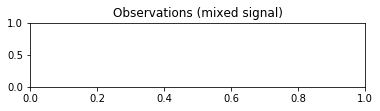

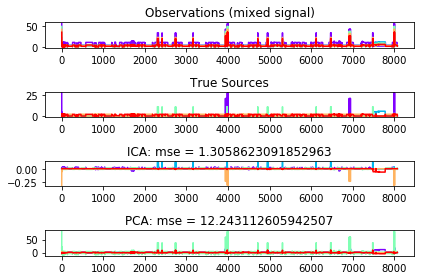

(8145, 5)
(8077, 5)
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=16, tm_hour=12, tm_min=10, tm_sec=37, tm_wday=1, tm_yday=289, tm_isdst=1) normalized
(8077, 5)
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=16, tm_hour=12, tm_min=10, tm_sec=37, tm_wday=1, tm_yday=289, tm_isdst=1) Amuse calculated


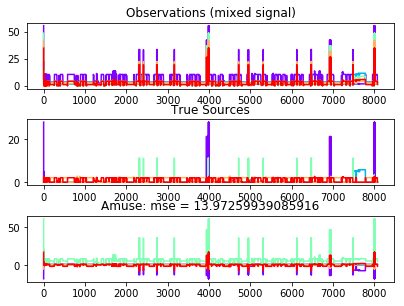

(8145, 5)
(8077, 5)
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=16, tm_hour=12, tm_min=10, tm_sec=38, tm_wday=1, tm_yday=289, tm_isdst=1) normalized
(8077, 5)
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=16, tm_hour=12, tm_min=10, tm_sec=38, tm_wday=1, tm_yday=289, tm_isdst=1) jade calculated


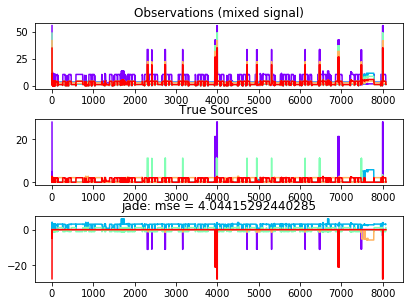

(8145, 5)
(8077, 5)
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=16, tm_hour=12, tm_min=10, tm_sec=38, tm_wday=1, tm_yday=289, tm_isdst=1) normalized
(8077, 5)
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=16, tm_hour=12, tm_min=10, tm_sec=38, tm_wday=1, tm_yday=289, tm_isdst=1) jade calculated


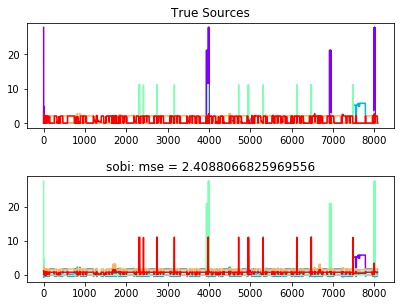

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn.decomposition import FastICA, PCA
from sklearn import preprocessing
import time
import sys
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from amuse import amuse
from jade import jadeR
from shogun import SOBI,RealFeatures

def get_signal_and_write_to_file(binsize=100000,fn='top10_pids_signal_fiu.csv'):
    import pickle
    small_trace = pickle.load(open('top_10_pids_fiu.pickle','rb'))
    e = pickle.load(open('top_pid_names.pickle','rb'))
    c = 0
    labels = {}
    for i in e:
        labels[i]=c
        c+=1

    start_time = small_trace[0][0]
    end_time = small_trace[-1][0]
    rows = ((end_time-start_time)/binsize)+1
    '''
   0-100000:     [0,0,0,0,0,223524623,0,0,0,0]
   100000-20000: [0,0,22434,0,0,0,0,346236,0,0]

Create the array:
signal = np.zeros((rows,len(labels)),dtype=np.uint32)
    '''  
    fo = open('binsize_'+str(binsize)+'-'+fn,'w')
    last = 0
    signal = np.zeros((1,len(labels)),dtype=np.uint32)
  # assume they're sorted, write 1 line at a time.
    for i in small_trace:
        ts=i[0]
        r = (ts-start_time)/binsize
        c = labels[i[2]]
        if r > last and not ((signal==0).all()):
            last = r
            fo.write(','.join(map(str,signal[0]))+',-,'+str(last)+'\n')
            signal = np.zeros((1,len(labels)),dtype=np.uint32)
        signal[0,c]=i[1]
   # signal[r,c] = i[1]
  # If multiple accesses are made to the same stream during a bin, we're
  # currently dropping all but the latest.  Another option is to add or average
  # them
    return True

#del small_trace
#print 'signal is',len(signal),'lines'
#signal = signal[~(signal==0).all(1)]
#print 'signal reduced to ',len(signal),'lines.  Pickling'
#fo = open('top10_pids_signal_fiu.csv','w')
#c=0
#for i in signal:
#  if not (i==0).all():
#    fo.write(','.join(map(str,i))+',-,'+str(c)+'\n')
#  c+=1
#pickle.dump(signal,open('top_10_pids_signal_fiu.pickle','wb'))
#time.sleep(10)
#print time.localtime(),'deleted small_trace'

from sklearn.metrics import mean_squared_error
import copy
def get_error(ground_truth,signalmat):
    # we want to try every possible signal order
    g=ground_truth.T
    s=signalmat.T
    l = len(s) # number of signals
    
    best_err =mean_squared_error(g,s)
    for j in range(l):        
        temp = copy.deepcopy(s[j])
        for i in range(j,l-1):
            s[i]=copy.deepcopy(s[i+1])
            s[i+1]=copy.deepcopy(temp)

            err = mean_squared_error(g,s)
            if err > best_err:
                best_err = err
    return best_err

def get_ica(fn = 'top10_pids_signal_fiu.csv'):
    
    signal=np.loadtxt(fn,delimiter=',',usecols=(3,5,7,8,9))#,3,4,5,6,7,8,9))
    print (signal.shape)
    signal = signal[~(signal==0).all(1)]
    print (signal.shape)
    signal /= signal.std(axis=0) #normalize
    print (time.localtime(),'normalized')
    print (signal.shape)
    nc = len(signal[0])

    A = np.array([[2, 0.3, 3, 1.5, 5], [0.5, 2, 1.0,1.5,.75], [1.75,1.5, 1.0,.5,2.0],[1.5,.75,2,1.25,1],[1.25,1,1.75,.5,2]])  # Mixing matrix
  #A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.75,1.5, 1.0]])  # Mixing matrix
    signal_ = np.dot(signal,A.T)
  # TODO: Show signals are statistically independent : some variant of Chi^2 test?
  # TODO: Show signals are not Gaussian (should be easy... )
  # TODO: Justify mixing matrix choice (must be full rank)
  # (http://www.tqmp.org/RegularArticles/vol06-1/p031/p031.pdf)
  # FIXME: Does Factor analsis not apply to non-Gaussians?
  # TODO: Attempt on "mixed" completely unlabeled data.
  # TODO: Attempt on more features
    print (signal_.shape)
  
  # Compute ICA
    ica = FastICA(n_components=nc)
    S_ = ica.fit_transform(signal_)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    print (time.localtime(),'ICA calculated')
    ica_err=get_error(signal,S_)#,np.mean(signal-abs(S_))

    pca = PCA(n_components=nc)
    H = pca.fit_transform(signal_)  # Reconstruct signals based on orthogonal components
    print (time.localtime(),'PCA calculated')
    pca_err=get_error(signal,H)

       
    fig=plt.figure()

    models = [signal_,signal, S_,H]
    names = ['Observations (mixed signal)',
           'True Sources',
           'ICA: mse = '+str(ica_err),
           'PCA: mse = '+str(pca_err)]
    colors=cm.rainbow(np.linspace(0,1,nc))

    for ii, (model, name) in enumerate(zip(models, names), 1):
        plt.subplot(4, 1, ii)
        plt.title(name)
        for sig, color in zip(model.T, colors):
            plt.plot(sig, color=color)

    plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
    fig.tight_layout() # show no overlap graph
    plt.show()

def get_amuse(fn = 'top10_pids_signal_fiu.csv'):
    
    signal=np.loadtxt(fn,delimiter=',',usecols=(3,5,7,8,9))#,3,4,5,6,7,8,9))
    print (signal.shape)
    
    signal = signal[~(signal==0).all(1)]
    print (signal.shape)
    d=signal.std(axis=0)
    signal =signal/d #normalize
    print (time.localtime(),'normalized')
    print (signal.shape)
    nc = len(signal[0])
      
    A = np.array([[2, 0.3, 3, 1.5, 5], [0.5, 2, 1.0,1.5,.75], [1.75,1.5, 1.0,.5,2.0],[1.5,.75,2,1.25,1],[1.25,1,1.75,.5,2]])  # Mixing matrix
#A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.75,1.5, 1.0]])  # Mixing matrix
    signal_ = np.dot(signal,A.T)
    
    #estimated sources
    amuse_me = amuse(signal_.T, 5, 1)
    s_hat = (amuse_me.sources).T

    print (time.localtime(),'Amuse calculated')
    amuse_err=get_error(signal,s_hat)
    
    plt.figure()

    models = [signal_,signal, s_hat]
    names = ['Observations (mixed signal)',
           'True Sources',
           'Amuse: mse = '+str(amuse_err)]
    colors=cm.rainbow(np.linspace(0,1,nc))

    for ii, (model, name) in enumerate(zip(models, names), 1):
        plt.subplot(3, 1, ii)
        plt.title(name)
        for sig, color in zip(model.T, colors):
            plt.plot(sig, color=color)

    plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
    plt.show()
        
    return

def get_jade(fn = 'top10_pids_signal_fiu.csv'):
    
    signal=np.loadtxt(fn,delimiter=',',usecols=(3,5,7,8,9))#,3,4,5,6,7,8,9))
    print (signal.shape)
    
    signal = signal[~(signal==0).all(1)]
    print (signal.shape)
    d=signal.std(axis=0)
    signal =signal/d #normalize
    print (time.localtime(),'normalized')
    print (signal.shape)
    nc = len(signal[0])
      
    A = np.array([[2, 0.3, 3, 1.5, 5], [0.5, 2, 1.0,1.5,.75], [1.75,1.5, 1.0,.5,2.0],[1.5,.75,2,1.25,1],[1.25,1,1.75,.5,2]])  # Mixing matrix
#A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.75,1.5, 1.0]])  # Mixing matrix
    signal_ = np.dot(signal,A.T)
    
    #estimated sources
    jade=np.asarray(jadeR(signal_.T,verbose=False))
    J=np.dot(jade,signal_.T)

    print (time.localtime(),'jade calculated')
    jade_err=get_error(signal,J.T)
    
    plt.figure()

    models = [signal_,signal, J.T]
    names = ['Observations (mixed signal)',
           'True Sources',
           'jade: mse = '+str(jade_err)]
    colors=cm.rainbow(np.linspace(0,1,nc))

    for ii, (model, name) in enumerate(zip(models, names), 1):
        plt.subplot(3, 1, ii)
        plt.title(name)
        for sig, color in zip(model.T, colors):
            plt.plot(sig, color=color)

    plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
    plt.show()
        
    return

def get_sobi(fn = 'top10_pids_signal_fiu.csv'):
    
    signal=np.loadtxt(fn,delimiter=',',usecols=(3,5,7,8,9))#,3,4,5,6,7,8,9))
    print (signal.shape)
    
    signal = signal[~(signal==0).all(1)]
    print (signal.shape)
    d=signal.std(axis=0)
    signal =signal/d #normalize
    print (time.localtime(),'normalized')
    print (signal.shape)
    nc = len(signal[0])
            
    #estimated sources
    sep = SOBI()
    signal_ = RealFeatures((signal.T).astype(np.float64))             
    signals = sep.apply(signal_)

    So = signals.get_feature_matrix()

    print (time.localtime(),'jade calculated')
    sobi_err=get_error(signal,So.T)
    
    plt.figure()

    models = [signal, So.T]
    names = [
           'True Sources',
           'sobi: mse = '+str(sobi_err)]
    colors=cm.rainbow(np.linspace(0,1,nc))

    for ii, (model, name) in enumerate(zip(models, names), 1):
        plt.subplot(2, 1, ii)
        plt.title(name)
        for sig, color in zip(model.T, colors):
            plt.plot(sig, color=color)

    plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
    plt.show()
        
    return

if __name__=='__main__':
  #get_signal_and_write_to_file(binsize=10000)

    get_ica(fn='first_10-min_binsize_10000-top10_pids_signal_fiu.csv')
    get_amuse(fn='first_10-min_binsize_10000-top10_pids_signal_fiu.csv') 
    get_jade(fn='first_10-min_binsize_10000-top10_pids_signal_fiu.csv')
    get_sobi(fn='first_10-min_binsize_10000-top10_pids_signal_fiu.csv')
  #get_ica(fn='top10_pids_signal_fiu.csv')
    #get_duet

In [ ]:
import numpy as np
from scipy.io.wavfile import read,write
import math
import numpy.ma as ma
np.set_printoptions(threshold=np.nan)
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tfanalysis import tfanalysis
from tfsynthesis import tfsynthesis
from twoDsmooth import twoDsmooth

################################################
#     setp 1,2,3
################################################ 
# 1. analyze the signals - STFT
# 1) Create the spectrogram of the Left and Right channels.

#constants used
pi=3.14159265359    
eps=2.2204e-16
wlen=1024;
timestep=512;
numfreq=1024;


awin=np.hamming(wlen) #analysis window is a Hamming window Looks like Sine on [0,pi]
x1=read('data/x1_reverb.wav')
x2=read('data/x2_reverb.wav')

fs=x1[0] # Obtain sampling rate

x1=x1[1]
#print(x1.dtype,"1")
x2=x2[1]

x1=x1/np.iinfo(x1.dtype).max # Dividing by maximum to normalise
x2=x2/np.iinfo(x2.dtype).max # Dividing by maximum to normalise


#  x1.shape is(65449,) 
tf1=tfanalysis(x1,awin,timestep,numfreq) #time-freq domain
#shape:(1024,721)
tf2=tfanalysis(x2,awin,timestep,numfreq) #time-freq domain

x1=np.asmatrix(x1)
x2=np.asmatrix(x2)
tf1=np.asmatrix(tf1)
tf2=np.asmatrix(tf2)

#removing DC component
tf1=tf1[1:,:]
tf2=tf2[1:,:]
#eps is the a small constant to avoid dividing by zero frequency in the delay estimation

#calculate pos/neg frequencies for later use in delay calc ??

a=np.arange(1,((numfreq/2)+1))
b=np.arange((-(numfreq/2)+1),0)
freq=(np.concatenate((a,b)))*((2*pi)/numfreq) #freq looks like saw signal

a=np.ones((tf1.shape[1],freq.shape[0]))
freq=np.asmatrix(freq)
a=np.asmatrix(a)
for i in range(a.shape[0]):
    a[i]=np.multiply(a[i],freq)
fmat=a.transpose()

####################################################

#2.calculate alpha and delta for each t-f point
#2) For each time/frequency compare the phase and amplitude of the left and
#   right channels. This gives two new coordinates, instead of time-frequency 
#   it is phase-amplitude differences.

R21 = (tf2+eps)/(tf1+eps)

#2.1HERE WE ESTIMATE THE RELATIVE ATTENUATION (alpha)
a=np.absolute(R21) #relative attenuation between the two mixtures
alpha=a-1./a #'alpha' (symmetric attenuation)
#2.2HERE WE ESTIMATE THE RELATIVE DELAY (delta)
delta = -(np.imag((np.log(R21)/fmat)))
# imaginary part, 'delta' relative delay
####################################################

# 3.calculate weighted histogram
# 3) Build a 2-d histogram (one dimension is phase, one is amplitude) where 
#    the height at any phase/amplitude is the count of time-frequency bins that
#    have approximately that phase/amplitude.

p=1; q=0;
h1=np.power(np.multiply(np.absolute(tf1),np.absolute(tf2)),p) #refer to run_duet.m line 45 for this. It's just the python translation of matlab 
h2=np.power(np.absolute(fmat),q)

tfweight=np.multiply(h1,h2) #weights vector 
maxa=0.7;
maxd=3.6;#histogram boundaries for alpha, delta

abins=35;
dbins=50;#number of hist bins for alpha, delta


# only consider time-freq points yielding estimates in bounds
amask=(abs(alpha)<maxa)&(abs(delta)<maxd)
amask=np.logical_not(amask)
alphavec = np.asarray(ma.masked_array(alpha, mask=(amask)).transpose().compressed())[0]
deltavec = np.asarray(ma.masked_array(delta, mask=(amask)).transpose().compressed())[0]
tfweight = np.asarray(ma.masked_array(tfweight, mask=(amask)).transpose().compressed())[0]
# to do masking the same way it is done in Matlab/Octave, after applying a mask we must take transpose and compress

#determine histogram indices (sampled indices?)

alphaind=np.around((abins-1)*(alphavec+maxa)/(2*maxa))
deltaind=np.around((dbins-1)*(deltavec+maxd)/(2*maxd))

#FULL-SPARSE TRICK TO CREATE 2D WEIGHTED HISTOGRAM
#A(alphaind(k),deltaind(k)) = tfweight(k), S is abins-by-dbins
A=sp.sparse.csr_matrix((tfweight, (alphaind, deltaind)),shape=(abins,dbins)).todense()
#smooththehistogram-localaverage3-by-3neighboringbins

A=twoDsmooth(A,3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X=np.linspace(-maxd,maxd,dbins)
Y=np.linspace(-maxa,maxa,abins)
X, Y = np.meshgrid(X, Y)
ax.plot_wireframe(X,Y,A)
plt.show()

# You can have a look at the histogram to look at the local peaks and what not

######################################    step 4,5,6,7
######################################
#4.peak centers (determined from histogram) THIS IS DONE BY HUMAN.
#4) Determine how many peaks there are in the histogram.
#5) Find the location of each peak. 

numsources=5;

peakdelta=np.array([-1.4, .66, 1.25, 1.9, .51]);
peakalpha=np.array([.4, -.29, .12, .66, -.5]);

#convert alpha to a

peaka=(peakalpha+np.sqrt(np.square(peakalpha)+4))/2;
peaka=np.asarray(peaka)

##################################################
#5.determine masks for separation
#6) Assign each time-frequency frame to the nearest peak in phase/amplitude 
#  space. This partitions the spectrogram into sources (one peak per source)

test = float("inf")
bestsofar=test*np.ones(tf1.shape)
bestind=np.zeros(tf1.shape)

for i in range(peakalpha.size):
    score = np.power(abs(np.multiply(peaka[i]*np.exp(-1j*fmat*peakdelta[i]),tf1)-tf2),2)/(1+peaka[i]*peaka[i])
    mask=score<bestsofar
    np.place(bestind,mask,i+1)
    s_mask=np.asarray(ma.masked_array(score, mask=np.logical_not(mask)).compressed())[0]
    np.place(bestsofar,mask,s_mask)

###################################################
#6.&7.demix with ML alignment and convert to time domain
#7) Then you create a binary mask (1 for each time-frequency point belonging to my source, 0 for all other points)
#8) Mask the spectrogram with the mask created in step 7.
#9) Rebuild the original wave file from 8.
#10) Listen to the result.

est=np.zeros((numsources,x1.shape[1]))
(row,col)=bestind.shape
for i in range(0,numsources):
    mask=ma.masked_equal(bestind,i+1).mask
    #here, 'h' stands for helper; we're using helper variables to break down the logic of
    # what's going on. Apologies for the order of the 'h's
    h1=np.zeros((1,tf1.shape[1]))
    h3=np.multiply((peaka[i]*np.exp(1j*fmat*peakdelta[i])),tf2)
    h4=((tf1+h3)/(1+peaka[i]*peaka[i]))
    h2=np.multiply(h4,mask)
    h=np.concatenate((h1,h2))

    esti=tfsynthesis(h,math.sqrt(2)*awin/1024,timestep,numfreq)

#add back into the demix a little bit of the mixture
#as that eliminates most of the masking artifacts

    est[i]=esti[0:x1.shape[1]]
    #est=est.astype(np.uint8) #Si add
    write('out'+str(i)+'.wav',fs,(np.asarray(est[i]+0.05*x1)[0]*100000).astype(np.int16))

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn.decomposition import FastICA, PCA
import time
import sys
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from amuse import amuse
from jade import jadeR
from sklearn.cluster import KMeans

def get_error(ground_truth,signalmat):
    # we want to try every possible signal order
    g=ground_truth.T
    s=signalmat.T
    l = len(s) # number of signals
    #best_err=np.mean(g-abs(s))
    best_err =mean_squared_error(g,s)
    for j in range(l):
        
        temp = s[0]
        for i in range(l-1):
            
            s[i]=s[i+1]
        s[l-1]=temp
        err = mean_squared_error(g,s)
        if err > best_err:
            best_err = err
    return best_err

def get_ica(fn):
    
    signal=pd.read_csv('out.csv') 
    X=signal.loc[:,["t", "hid","uid","sys","dev","fid","gfid","ofst","byts","fd","fpd","cFlg","ftyp","fstp","uid","siz","nlnk","ctm","mtm","atm","mode",]]
    y=signal.iloc[1:,-1]
    print (X.shape)

    print (X.shape)
    X /= X.std(axis=0) #normalize
    #print(X)
    print (time.localtime(),'normalized')

    nc = 10    
  # Compute ICA

    ica = FastICA(n_components=nc)
    X_ICA = ica.fit_transform(X)  # Reconstruct signals
    kmeans_ica = KMeans(n_clusters=2,random_state=0).fit(X_ICA)
    labels_ica = kmeans_ica.labels_
    print (time.localtime(),'ICA calculated')
    #ica_err=get_error(y,X_ICA)#,np.mean(signal-abs(S_))

    pca = PCA(n_components=nc)
    X_PCA = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components
    kmeans_pca = KMeans(n_clusters=2,random_state=0).fit(X_PCA)
    labels_pca = kmeans_pca.labels_
    print (time.localtime(),'PCA calculated')
    #pca_err=get_error(y,X_PCA)



    
if __name__=='__main__':
    get_ica(fn='out.cvs')

(43, 21)
(43, 21)
time.struct_time(tm_year=2018, tm_mon=9, tm_mday=7, tm_hour=17, tm_min=33, tm_sec=29, tm_wday=4, tm_yday=250, tm_isdst=1) normalized
time.struct_time(tm_year=2018, tm_mon=9, tm_mday=7, tm_hour=17, tm_min=33, tm_sec=29, tm_wday=4, tm_yday=250, tm_isdst=1) ICA calculated
time.struct_time(tm_year=2018, tm_mon=9, tm_mday=7, tm_hour=17, tm_min=33, tm_sec=29, tm_wday=4, tm_yday=250, tm_isdst=1) PCA calculated


C:\Users\Si\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [45]:
import numpy as np
import pandas as pd
import csv
fn='out.csv'
signal=pd.read_csv('out.csv') 
X=signal.loc[:,['pid','sys']]
#X = np.array(signal)[:,:-1]
#X = signal[1:2,:]
y=signal[['label']]
print(X)

    pid  sys
0     0    1
1     0    3
2     0    1
3     0    4
4     0   38
5     0   38
6     0    5
7     0    3
8     0   38
9     0   92
10    0   12
11    0   59
12    0    2
13    0    2
14    0    1
15    0    8
16    0   12
17    0   59
18    0    2
19    0    5
20    0   92
21    0  272
22    0  195
23    0    5
24    0   92
25    0    5
26    0   92
27    0  272
28    0    1
29    0    1
30    0    2
31    0    2
32    0    1
33    0    2
34    0    2
35    0   59
36    0    5
37    0    3
38    0   71
39    0   71
40    0    5
41    0   92
42    0    3


In [44]:
k=signal.iloc[3]
print(k)

t        842425200
hid             34
uid            195
pid              0
sys              4
dev             -9
fid             -9
gfid             0
comd             0
ofst            -9
byts            79
fd               0
fpd              0
cFlg             0
ftyp             0
fstp             0
uid.1            0
siz              0
nlnk             0
ctm              0
mtm              0
atm              0
mode             0
label            0
Name: 3, dtype: int64


In [25]:
print(X)

            t  hid    uid  pid  sys  dev  fid  gfid  comd  ofst  ...   cFlg  \
1   842425200   33   6197    0    3   -9   -9     0     0    -9  ...      0   
2   842425200   33   6197    0    1    0    0     0     0     0  ...      0   
3   842425200   34    195    0    4   -9   -9     0     0    -9  ...      0   
4   842425200   34   4709    0   38   34    1     1     0     0  ...      0   
5   842425200   34   4709    0   38   34    1     1     0     0  ...      0   
6   842425200   34   4709    0    5   34    1     1     0     0  ...      0   
7   842425200   34   4709    0    3   34    1     1     0     0  ...      0   
8   842425200   34    114    0   38   34    2     2     0     0  ...      0   
9   842425200   34    114    0   92   -9   -9     0     0     0  ...      0   
10  842425200   26   4719    0   12   26    1     3     0     0  ...      0   
11  842425200   26   4719    0   59   26    2     4     0     0  ...      0   
12  842425200   26   4719    0    2    0    0     0 

In [53]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
              [4, 2], [4, 4], [4, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print(kmeans.labels_)

print(kmeans.predict([[0, 0], [4, 4]]))

print(kmeans.cluster_centers_)

[0 0 0 1 1 1]
[0 1]
[[ 1.  2.]
 [ 4.  2.]]
